In [1]:
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# PAYOFF MATRIX
# -----------------------------
# Payoffs for (player, opponent)
# R = Reward (mutual cooperation)
# G = Greediness (you defect, they cooperate)
# D = Destiny (mutual defection)
# L = Loss (you cooperate, they defect)

# G>R>D>L and 2R>G+L
# Typical example: G=5,R=3,D=1,L=0

R, G, D, L = 3, 5, 1, 0
PAYOFFS = {
    ('C', 'C'): (R, R),
    ('C', 'D'): (L, G),
    ('D', 'C'): (G, L),
    ('D', 'D'): (D, D)
}

In [3]:
# -----------------------------
# STRATEGY DEFINITIONS
# -----------------------------
class Strategy:
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.history = []

    def move(self, opponent_history):
        raise NotImplementedError


class Cooperator(Strategy):
    def __init__(self): super().__init__("Cooperator")
    def move(self, opponent_history): return 'C'


class Cheater(Strategy):
    def __init__(self): super().__init__("Cheater")
    def move(self, opponent_history): return 'D'


class Copycat(Strategy):
    def __init__(self): super().__init__("Copycat")
    def move(self, opponent_history):
        return 'C' if not opponent_history else opponent_history[-1]


class Grudger(Strategy):
    def __init__(self):
        super().__init__("Grudger")
        self.grudge = False
    def reset(self):
        super().reset(); self.grudge = False
    def move(self, opponent_history):
        if 'D' in opponent_history:
            self.grudge = True
        return 'D' if self.grudge else 'C'


class Detective(Strategy):
    def __init__(self):
        super().__init__("Detective")
        self.probe_moves = ['D', 'C', 'C', 'D']
    def reset(self):
        super().reset(); self.phase = "probe"
    def move(self, opponent_history):
        if len(self.history) < 4:
            return self.probe_moves[len(self.history)]
        if 'D' not in opponent_history:
            return 'D'  # exploit
        else:
            return opponent_history[-1]  # play Copycat


class Copykitten(Strategy):
    def __init__(self): super().__init__("Copykitten")
    def move(self, opponent_history):
        if len(opponent_history) < 2:
            return 'C'
        if opponent_history[-1] == 'D' and opponent_history[-2] == 'D':
            return 'D'
        return 'C'

In [4]:
# -----------------------------
# GAME MECHANICS
# -----------------------------

def play_round(p1, p2, noise=0.0):
    """Play one noisy round."""
    m1 = p1.move(p2.history)
    m2 = p2.move(p1.history)

    if random.random() < noise: m1 = 'D' if m1 == 'C' else 'C'
    if random.random() < noise: m2 = 'D' if m2 == 'C' else 'C'

    p1.history.append(m1)
    p2.history.append(m2)
    return PAYOFFS[(m1, m2)]


def play_match(p1, p2, rounds=50, noise=0.0):
    """Run multiple rounds and return average payoffs."""
    p1.reset(); p2.reset()
    total1 = total2 = 0
    for _ in range(rounds):
        pay1, pay2 = play_round(p1, p2, noise)
        total1 += pay1
        total2 += pay2
    return total1 / rounds, total2 / rounds


def tournament(strategies, rounds=50, noise=0.0):
    """Compute the full payoff matrix between all strategies."""
    n = len(strategies)
    payoff_matrix = np.zeros((n, n))
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            avg1, _ = play_match(s1, s2, rounds, noise)
            payoff_matrix[i, j] = avg1
    return payoff_matrix

In [5]:
def evolve(strategies, generations=50, noise=0.05, rounds=50, initial_freq=None):
    names = [s.name for s in strategies]
    n = len(strategies)

    # Initialize frequencies
    if initial_freq is None:
        freqs = np.ones(n) / n
    else:
        freqs = np.array(initial_freq) / sum(initial_freq)

    history = [freqs.copy()]

    for g in range(generations):
        payoff_matrix = tournament(strategies, rounds, noise)
        avg_payoffs = payoff_matrix.dot(freqs)
        mean_fitness = np.dot(freqs, avg_payoffs)

        # Replicator equation
        freqs = freqs * (avg_payoffs / mean_fitness)
        freqs /= freqs.sum()  # normalize to sum=1
        history.append(freqs.copy())

    return np.array(history), names

In [6]:
# # -----------------------------
# # MAIN
# # -----------------------------

# if __name__ == "__main__":
#     random.seed(42)
#     np.random.seed(42)

#     strategies = [
#         Cooperator(),
#         Cheater(),
#         # Copycat(),
#         # Grudger(),
#         # Detective(),
#         # Copykitten()
#     ]

#     generations = 100
#     rounds = 100
#     noise = 0.05
#     # mutation_rate = 0.05
    
#     history, names = evolve(
#         strategies,
#         generations=generations,
#         rounds=rounds,
#         noise=noise
#     )

#     # Plot evolution
#     plt.figure(figsize=(10,6))
#     for i, name in enumerate(names):
#         plt.plot(history[:, i], label=name)
#     # plt.title("Evolution of Trust — Replicator-Mutator Dynamics")
#     # plt.title(f"Evolution of Trust — noise={noise:.2f}, mutation={mutation_rate:.2f}")
#     plt.title(f"Evolution of Trust (Cooperator vs Cheater) \n noise={noise:.2f}")
#     plt.xlabel("Generation")
#     plt.ylabel("Population Frequency")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# Simple World

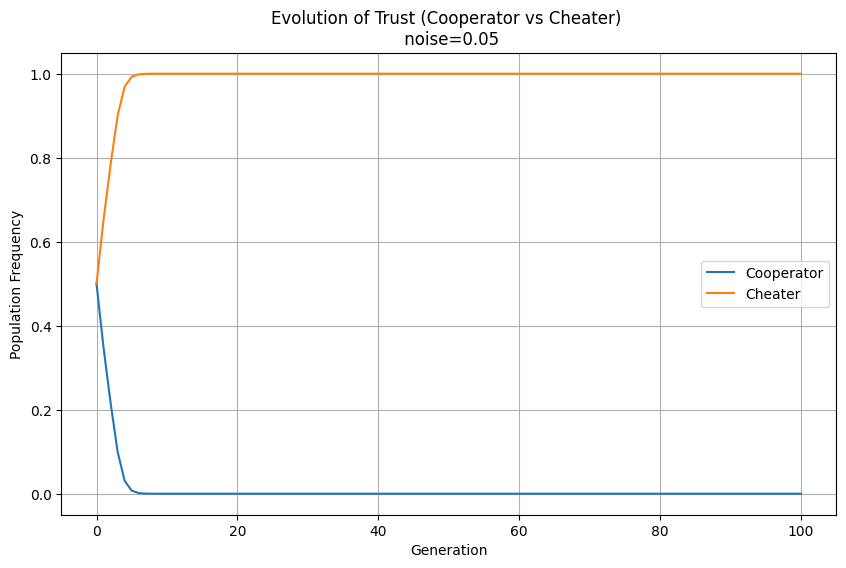

In [7]:
# Run basic simulation

random.seed(42)
np.random.seed(42)

strategies = [Cooperator(),Cheater()]

noise=0.05
history, names = evolve(strategies=strategies, generations=100, rounds=100, noise=noise)

# Plot 
plt.figure(figsize=(10,6))
for i, name in enumerate(names):
    plt.plot(history[:, i], label=name)
plt.title(f"Evolution of Trust (Cooperator vs Cheater) \n noise={noise:.2f}")
plt.xlabel("Generation")
plt.ylabel("Population Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Complex World

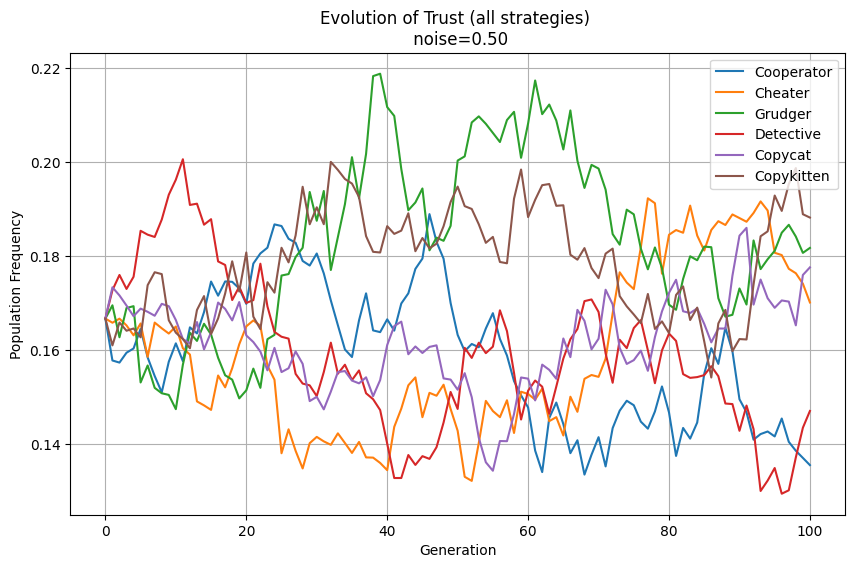

In [8]:
# Run complex simulation

random.seed(42)
np.random.seed(42)

strategies = [Cooperator(),Cheater(),Grudger(),Detective(),Copycat(),Copykitten()]

noise=0.50
history, names = evolve(strategies=strategies, generations=100, rounds=100, noise=noise)

# Plot 
plt.figure(figsize=(10,6))
for i, name in enumerate(names):
    plt.plot(history[:, i], label=name)
plt.title(f"Evolution of Trust (all strategies) \n noise={noise:.2f}")
plt.xlabel("Generation")
plt.ylabel("Population Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Mutation

In [9]:
# -----------------------------
# EVOLUTION WITH MUTATION
# -----------------------------

def evolve_with_mutation(strategies, generations=100, rounds=100, noise=0.05,
           mutation_rate=0.01, initial_freq=None):
    """
    Simulate replicator-mutator dynamics.
    Each generation: 
    - strategies play
    - reproduce proportionally to payoff
    - small chance of mutation between strategies
    """
    names = [s.name for s in strategies]
    n = len(strategies)

    if initial_freq is None:
        freqs = np.ones(n) / n
    else:
        freqs = np.array(initial_freq) / sum(initial_freq)

    history = [freqs.copy()]

    for gen in range(generations):
        payoff_matrix = tournament(strategies, rounds, noise)
        avg_payoffs = payoff_matrix.dot(freqs)
        mean_fitness = np.dot(freqs, avg_payoffs)

        # Replicator step
        new_freqs = freqs * (avg_payoffs / mean_fitness)

        # Mutation step (uniform small probability of switching)
        mutation_matrix = np.ones((n, n)) * (mutation_rate / (n - 1))
        np.fill_diagonal(mutation_matrix, 1 - mutation_rate)
        new_freqs = mutation_matrix.T.dot(new_freqs)

        # Normalize
        new_freqs /= new_freqs.sum()
        freqs = new_freqs
        history.append(freqs.copy())

    return np.array(history), names

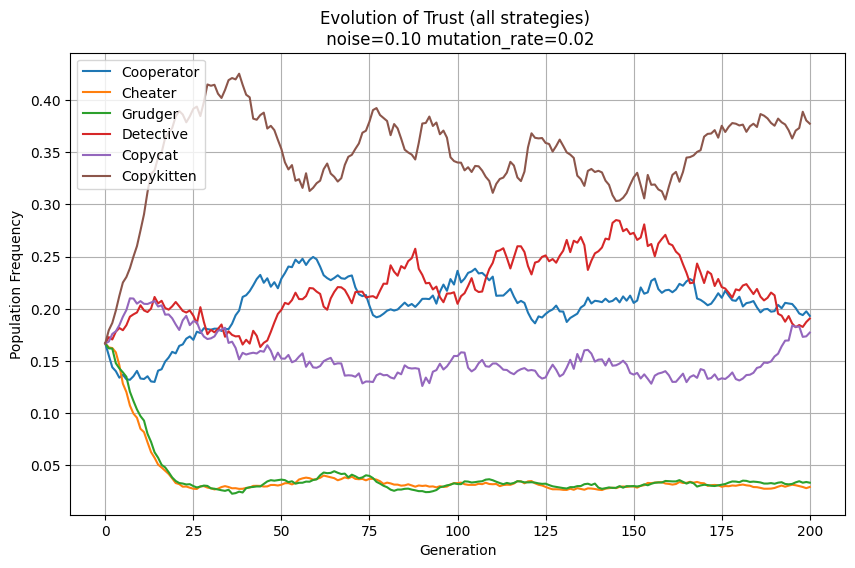

In [10]:
# Run complex simulation

random.seed(42)
np.random.seed(42)

strategies = [Cooperator(),Cheater(),Grudger(),Detective(),Copycat(),Copykitten()]

noise=0.10
mutation_rate=0.02
history, names = evolve_with_mutation(strategies=strategies, generations=200, rounds=100, noise=noise, mutation_rate=mutation_rate)

# Plot 
plt.figure(figsize=(10,6))
for i, name in enumerate(names):
    plt.plot(history[:, i], label=name)
plt.title(f"Evolution of Trust (all strategies) \n noise={noise:.2f} mutation_rate={mutation_rate:.2f}")
plt.xlabel("Generation")
plt.ylabel("Population Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Intervention

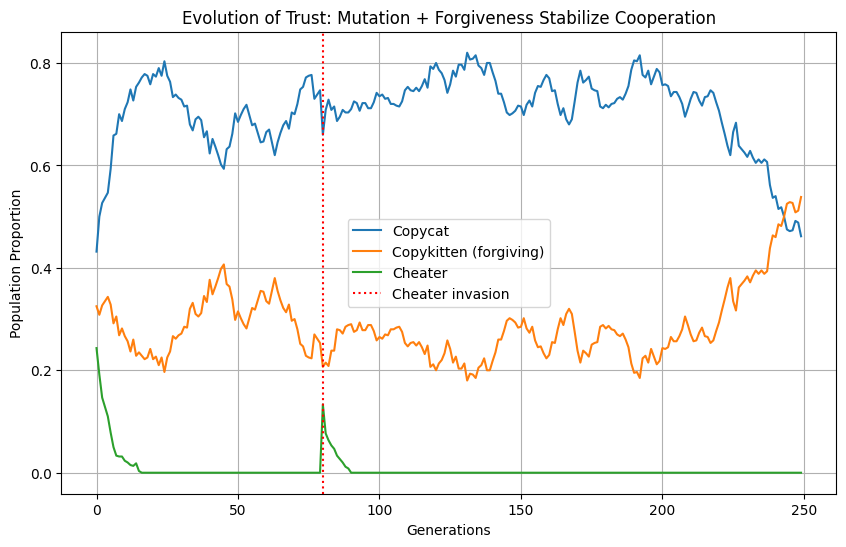

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
n_generations = 250
population_size = 600
initial_ratios = [0.4, 0.3, 0.3]  # Copycat, Copykitten, Cheater
mutation_rate = 0.02
noise = 0.0

# Payoff matrix (G, R, D, S)
G, R, D, L = 5, 3, 1, 0

# Define strategies: C = Copycat, K = Copykitten, D = Cheater
def play_iterated_game(strat_a, strat_b, rounds=5):
    """Play several rounds between two strategies and return total payoffs."""
    payoff_a, payoff_b = 0, 0
    last_a, last_b = "C", "C"
    cheat_streak_a, cheat_streak_b = 0, 0

    for _ in range(rounds):
        # Decide moves
        if strat_a == "C":  # Copycat
            move_a = "C" if last_b != "D" else "D"
        elif strat_a == "K":  # Copykitten
            move_a = "D" if cheat_streak_b >= 2 else "C"
        else:  # Cheater
            move_a = "D"

        if strat_b == "C":
            move_b = "C" if last_a != "D" else "D"
        elif strat_b == "K":
            move_b = "D" if cheat_streak_a >= 2 else "C"
        else:
            move_b = "D"

        # Compute payoffs
        if move_a == "C" and move_b == "C":
            pa, pb = R, R
        elif move_a == "C" and move_b == "D":
            pa, pb = L, G
        elif move_a == "D" and move_b == "C":
            pa, pb = G, L
        else:
            pa, pb = D, D

        payoff_a += pa
        payoff_b += pb

        # Update memory
        cheat_streak_a = cheat_streak_a + 1 if move_a == "D" else 0
        cheat_streak_b = cheat_streak_b + 1 if move_b == "D" else 0
        last_a, last_b = move_a, move_b

    return payoff_a, payoff_b


def simulate(mutation_rate=0.02):
    strategies = np.random.choice(["C", "K", "D"], size=population_size, p=initial_ratios)
    hist_C, hist_K, hist_D = [], [], []

    for gen in range(n_generations):
        fitness = np.zeros(population_size)

        # Random interactions
        for i in range(population_size):
            opponents = np.random.choice(population_size, 10, replace=False)
            for j in opponents:
                p_i, p_j = play_iterated_game(strategies[i], strategies[j])
                fitness[i] += p_i
                fitness[j] += p_j

        # Selection proportional to fitness
        fitness = np.maximum(fitness, 0.01)
        probs = fitness / np.sum(fitness)
        new_strategies = np.random.choice(strategies, size=population_size, p=probs)

        # # Apply mutation
        # for i in range(population_size):
        #     if np.random.rand() < mutation_rate:
        #         new_strategies[i] = np.random.choice(["C", "K", "D"])

        strategies = new_strategies

        # Introduce cheaters mid-simulation to simulate invasion
        if gen == 80:
            cheater_indices = np.random.choice(population_size, 80, replace=False)
            strategies[cheater_indices] = "D"

        # Record proportions
        hist_C.append(np.mean(strategies == "C"))
        hist_K.append(np.mean(strategies == "K"))
        hist_D.append(np.mean(strategies == "D"))

    return np.array(hist_C), np.array(hist_K), np.array(hist_D)


random.seed(42)
np.random.seed(42)

# Run simulation
hist_C, hist_K, hist_D = simulate(mutation_rate=mutation_rate)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(hist_C, label="Copycat")
plt.plot(hist_K, label="Copykitten (forgiving)")
plt.plot(hist_D, label="Cheater")
plt.axvline(80, color='red', linestyle=':', label="Cheater invasion")
plt.xlabel("Generations")
plt.ylabel("Population Proportion")
plt.title("Evolution of Trust: Mutation + Forgiveness Stabilize Cooperation")
plt.legend()
plt.grid(True)
plt.show()


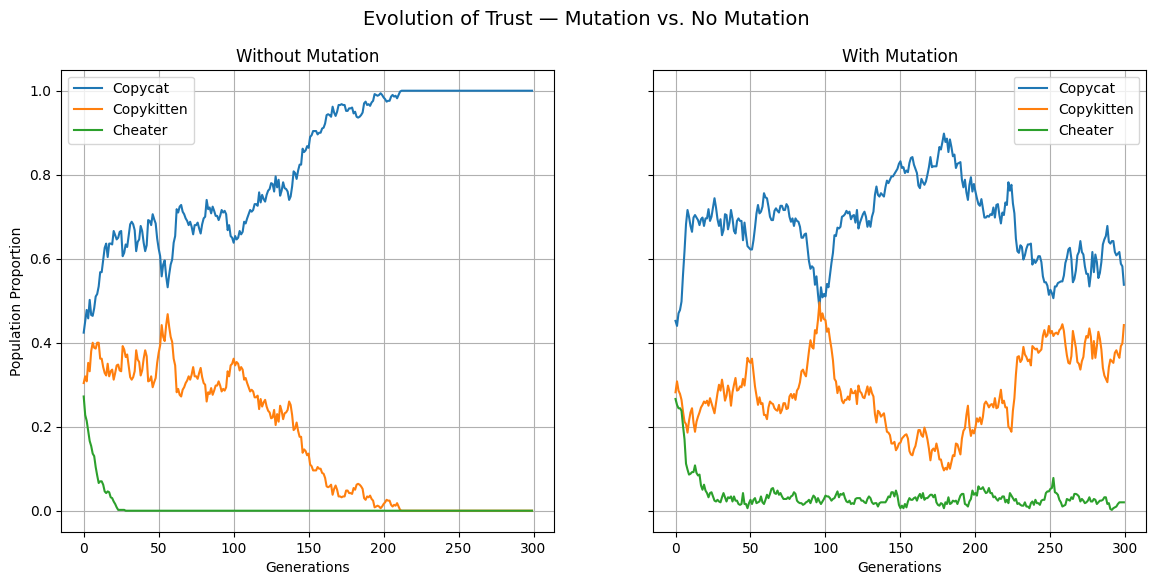

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- Payoff constants (Prisoner's Dilemma) ---
T, R, P, S = 5, 3, 1, 0  # Temptation, Reward, Punishment, Sucker payoff

# --- Strategy logic ---
def play_iterated_game(strat_a, strat_b, rounds=5, noise=0.0):
    payoff_a, payoff_b = 0, 0
    last_a, last_b = "C", "C"
    cheat_streak_a, cheat_streak_b = 0, 0

    for _ in range(rounds):
        # Player A strategy
        if strat_a == "C":  # Copycat
            intended_a = "C" if last_b != "D" else "D"
        elif strat_a == "K":  # Copykitten
            intended_a = "D" if cheat_streak_b >= 2 else "C"
        else:  # Cheater
            intended_a = "D"

        # Player B strategy
        if strat_b == "C":
            intended_b = "C" if last_a != "D" else "D"
        elif strat_b == "K":
            intended_b = "D" if cheat_streak_a >= 2 else "C"
        else:
            intended_b = "D"

        # Noise (flip intended move)
        def noisy(move):
            if np.random.rand() < noise:
                return "D" if move == "C" else "C"
            return move

        move_a, move_b = noisy(intended_a), noisy(intended_b)

        # Payoffs
        if move_a == "C" and move_b == "C":
            pa, pb = R, R
        elif move_a == "C" and move_b == "D":
            pa, pb = S, T
        elif move_a == "D" and move_b == "C":
            pa, pb = T, S
        else:
            pa, pb = P, P

        payoff_a += pa
        payoff_b += pb

        # Update memory
        cheat_streak_a = cheat_streak_a + 1 if move_a == "D" else 0
        cheat_streak_b = cheat_streak_b + 1 if move_b == "D" else 0
        last_a, last_b = move_a, move_b

    return payoff_a, payoff_b


def simulate(mutation_rate, noise=0.05, generations=300, pop_size=500):
    strategies = np.random.choice(["C", "K", "D"], size=pop_size, p=[0.4, 0.3, 0.3])
    history = {"C": [], "K": [], "D": []}

    for _ in range(generations):
        fitness = np.zeros(pop_size)

        # Each agent plays with 10 random opponents
        for i in range(pop_size):
            opponents = np.random.choice(pop_size, 10, replace=False)
            for j in opponents:
                p_i, p_j = play_iterated_game(strategies[i], strategies[j], noise=noise)
                fitness[i] += p_i
                fitness[j] += p_j

        # Reproduction proportional to fitness
        fitness = np.maximum(fitness, 0.01)
        probs = fitness / np.sum(fitness)
        new_strategies = np.random.choice(strategies, size=pop_size, p=probs)

        # Apply mutation
        for i in range(pop_size):
            if np.random.rand() < mutation_rate:
                new_strategies[i] = np.random.choice(["C", "K", "D"])

        strategies = new_strategies

        # Record proportions
        for s in ["C", "K", "D"]:
            history[s].append(np.mean(strategies == s))

    return history


random.seed(42)
np.random.seed(42)

# --- Run simulations ---
no_mutation = simulate(mutation_rate=0.0)
with_mutation = simulate(mutation_rate=0.02)

# --- Plot results ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Without mutation
for s, label in zip(["C", "K", "D"], ["Copycat", "Copykitten", "Cheater"]):
    axes[0].plot(no_mutation[s], label=label)
axes[0].set_title("Without Mutation")
axes[0].set_xlabel("Generations")
axes[0].set_ylabel("Population Proportion")
axes[0].grid(True)
axes[0].legend()

# With mutation
for s, label in zip(["C", "K", "D"], ["Copycat", "Copykitten", "Cheater"]):
    axes[1].plot(with_mutation[s], label=label)
axes[1].set_title("With Mutation")
axes[1].set_xlabel("Generations")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Evolution of Trust — Mutation vs. No Mutation", fontsize=14)
plt.show()
